In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import cv2
import os

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers



In [13]:
def load_images_from_folder(folder,eyes):
    images=[]
    for filename in os.listdir(folder):
        img=cv2.imread(os.path.join(folder,filename))
        img=cv2.resize(img,(80,80))
        images.append([img,eyes])
    return images

In [14]:

folder="/content/drive/MyDrive/train2/train/Open_Eyes"
open_eyes=load_images_from_folder(folder,0)

folder="/content/drive/MyDrive/train2/train/Closed_Eyes"
closed_eyes=load_images_from_folder(folder,1)


In [15]:
#Number of Images
#
print(len(open_eyes))
print(len(closed_eyes))

2000
2000


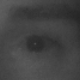

In [16]:
#Displaying image to confirm that they have been loaded 
from PIL import Image as im
data=im.fromarray(open_eyes[0][0])
data

In [17]:
#Combining the open and closed eye data 
eyes=open_eyes+closed_eyes

In [18]:
#Setting up images with X being images and y being labels
X=[]
y=[]

for features, label in eyes:
    X.append(features)
    y.append(label)



In [19]:
#Converting image to array for modelling and scaling by dividing by 255
X=np.array(X).reshape(-1,80,80,3)
y=np.array(y)
X=X/255.0

In [20]:
# Splitting the data 

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=23 )


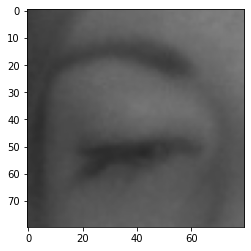

In [21]:
#confirming that split ran okay

plt.figure()
plt.imshow(X_train[10])
plt.show()

In [22]:
#class names for images shown below 

class_names=['open','close']

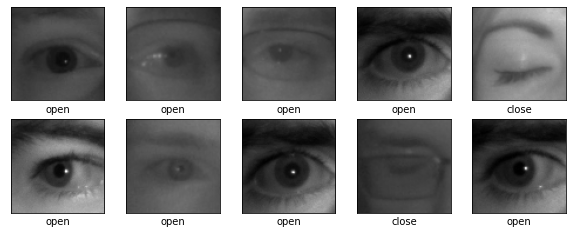

In [23]:
#producing images of training set with corresponding label
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]],)

In [24]:
#Reshping imags to 80*80*3 just incase 
X_train=X_train.reshape(X_train.shape[0], 80,80,3)
X_test=X_test.reshape(X_test.shape[0], 80,80,3)

In [25]:
def deep_learning_model(dense_neurons1=128,dense_neurons2=128,dense_neurons3=128,layout='',filters=32,dropout=None,pooling=None):
  model=Sequential()
  if layout== '5x5':
    model.add(Conv2D(filters=filters, kernel_size=(5,5),activation='relu',input_shape=(80,80,3)))

  if layout=='3x3'or layout== '2*3x3':
    model.add(Conv2D(filters=filters,kernel_size=(3,3),activation='relu',input_shape=(80,80,3)))

#adding pooling for convlutional layers
  if pooling!=None:
    model.add(MaxPooling2D(pool_size=(2,2)))

  if layout=='2*3x3':
    #second layer
      model.add(Conv2D(filters=filters,kernel_size=(3,3),activation='relu',input_shape=(80,80,3)))
#adding pooling on 2*3x3
  if pooling !=None and layout =='2*3x3':
    model.add(MaxPooling2D(pool_size=(2,2)))

#flatten model for dense layers
  model.add(Flatten())
  model.add(Dense(dense_neurons1,activation='relu'))
  if dropout!=None:
    model.add(Dropout(dropout))
  model.add(Dense(dense_neurons2,activation='relu'))
  if dropout!=None:
    model.add(Dropout(dropout))
  model.add(Dense(dense_neurons3,activation='relu'))
  if dropout!=None:
    model.add(Dropout(dropout))

#adding output layer

  model.add(Dense(1,activation='sigmoid'))

  #compiling using binary cross entropy and using AUC as metric 
  model.compile(loss='binary_crossentropy', optimizer='adam',metrics=[tf.keras.metrics.AUC(curve='PR')])

  return model







    


In [26]:
early_stop=tf.keras.callbacks.EarlyStopping(patience=5, min_delta=.05)

In [27]:
params_deep={
    "layout":['3x3','5x5','2*3x3'],
    "dense_neurons1":[64,128],
    'filters':[8,18,32],
    "dropout":[0.1,0.5,],
    "pooling":[None,1],
    "epochs":[10]

}

In [28]:
nn_deep=KerasClassifier(build_fn=deep_learning_model, batch_size=200)
gs_deep=GridSearchCV(estimator=nn_deep,param_grid=params_deep,cv=3,scoring='average_precision')
#gs_deep.fit(X_train, y_train,validation_data=(X_test,y_test),callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [29]:


#Summary of thescores

#means = gs_deep.cv_results_['mean_test_score']
#stds = gs_deep.cv_results_['std_test_score']
#params = gs_deep.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
    #print(f' mean={mean:.4}, std={stdev:.4} using {param}')


In [30]:
#print(f'Best Accuracy for {gs_deep.best_score_} using {gs_deep.best_params_}')


From this grid search we find the best layout to be 2*3x3 with 32 filters. This means we will have two convolution layers with a kernel size of (3,3) representing the height and width of the filter. We will perform other iterations on the same layout but with three layers of dense neurons and different hyperparameters.

In [31]:
params_deep_two={
    "layout":['2*3x3'],
    "dense_neurons1":[128,256],
    "dense_neurons2":[256,512],
    "dense_neurons3":[256,512],
    'filters':[32],
    "dropout":[0,0.1,0.3,0.5,],
    "pooling":[None,1],
    "epochs":[20]

}

In [32]:
nn_deep=KerasClassifier(build_fn=deep_learning_model, batch_size=200)
gs_deep=GridSearchCV(estimator=nn_deep,param_grid=params_deep_two,cv=3,scoring='average_precision')
#gs_deep.fit(X_train, y_train,validation_data=(X_test,y_test),callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [33]:
#Summary of the results
#means = gs_deep.cv_results_['mean_test_score']
#stds = gs_deep.cv_results_['std_test_score']
#params = gs_deep.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
    #print(f' mean={mean:.4}, std={stdev:.4} using {param}')

In [34]:
#print(f'Best Accuracy for {gs_deep.best_score_} using {gs_deep.best_params_}')

Given that we have an accuracy of 0.998397543919476, which is better than the neural network architecture with one dense layer at 0.999472216392248  , we can take these as the  parameters to build our final model.

Final model for Export

AUC score of model produced by grid search: 0.9998397543919476

Parameters of best model produced by grid search:

dense_neurons1: 256,
dense_neurons2: 512,
dense_neurons3: 512, 
dropout: 0.3, 
epochs: 20, 
filters: 32, 
layout: '2*3x3', 
pooling: 1




In [35]:
#instantiate the model
model=Sequential()

#adding first convolution layer
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
#maxpooling after convolution layer
model.add(MaxPooling2D(pool_size=(2,2)))

#adding another convolution layer
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
#maxpooling after convolution layer
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

#adding first dense layer with 256 nodes
model.add(Dense(256, activation='relu'))
#adding a dropout layer to avoid overfitting
model.add(Dropout(0.3))

#adding second dense layer with 512 nodes
model.add(Dense(512, activation='relu'))
#adding a dropout layer to avoid overfitting
model.add(Dropout(0.3))

#adding third dense layer with 512 nodes
model.add(Dense(512, activation='relu'))
#adding a dropout layer to avoid overfitting
model.add(Dropout(0.3))

#Output layer
model.add(Dense(1, activation='sigmoid'))
#compiling 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[tf.keras.metrics.AUC(curve='PR')])

#fitting on train data
model.fit(X_train,y_train,batch_size=200, epochs=20)

Epoch 1/20
15/15 [==============================] - 14s 31ms/step - loss: 0.5480 - auc: 0.7836
Epoch 2/20
15/15 [==============================] - 0s 31ms/step - loss: 0.1873 - auc: 0.9790
Epoch 3/20
15/15 [==============================] - 0s 31ms/step - loss: 0.0588 - auc: 0.9979
Epoch 4/20
15/15 [==============================] - 0s 31ms/step - loss: 0.0454 - auc: 0.9974
Epoch 5/20
15/15 [==============================] - 0s 31ms/step - loss: 0.0205 - auc: 0.9996
Epoch 6/20
15/15 [==============================] - 0s 31ms/step - loss: 0.0098 - auc: 0.9999
Epoch 7/20
15/15 [==============================] - 0s 31ms/step - loss: 0.0063 - auc: 1.0000
Epoch 8/20
15/15 [==============================] - 0s 31ms/step - loss: 0.0046 - auc: 1.0000
Epoch 9/20
15/15 [==============================] - 0s 31ms/step - loss: 0.0061 - auc: 1.0000
Epoch 10/20
15/15 [==============================] - 0s 31ms/step - loss: 0.0050 - auc: 1.0000
Epoch 11/20
15/15 [==============================] - 0s 31

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (200, 78, 78, 32)         896       
                                                                 
 max_pooling2d (MaxPooling2D  (200, 39, 39, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (200, 37, 37, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (200, 18, 18, 32)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (200, 10368)              0         
                                                                 
 dense (Dense)               (200, 256)                2

In [37]:
#Evaluating model on test data
score=model.evaluate(X_test,y_test, verbose=1)

labels=model.metrics_names

#showing perfomance
print(f'{labels[0]}: {score[0]}')

print(f'{labels[1]}: {score[1]}')

32/32 [==============================] - 1s 6ms/step - loss: 0.0061 - auc: 0.9980
loss: 0.00613695103675127
auc: 0.9979591965675354


In [38]:
preds=model.predict(X_test)
preds.round(1)
preds

array([[1.21515910e-20],
       [1.00000000e+00],
       [3.93943192e-05],
       [9.99999166e-01],
       [1.00000000e+00],
       [4.37719694e-10],
       [9.99998331e-01],
       [6.91648665e-07],
       [1.11571853e-06],
       [5.66080462e-06],
       [1.00000000e+00],
       [9.99997377e-01],
       [8.28947577e-07],
       [9.68556013e-10],
       [3.10755786e-06],
       [1.00000000e+00],
       [9.95557129e-01],
       [1.00000000e+00],
       [4.24015005e-16],
       [1.00000000e+00],
       [9.99999642e-01],
       [1.00000000e+00],
       [1.34610041e-20],
       [1.78590308e-05],
       [1.00000000e+00],
       [9.80997226e-19],
       [5.05926617e-19],
       [3.84871091e-05],
       [9.99986410e-01],
       [1.00000000e+00],
       [9.91050262e-21],
       [1.00000000e+00],
       [1.11037343e-11],
       [1.00000000e+00],
       [1.00000000e+00],
       [8.48851878e-10],
       [1.69096970e-09],
       [1.32325101e-06],
       [9.99999166e-01],
       [9.99999523e-01],


In [39]:
confusion_matrix=tf.math.confusion_matrix(labels=y_test,predictions=preds.round()).numpy()

confusion_matrix

array([[509,   1],
       [  0, 490]], dtype=int32)

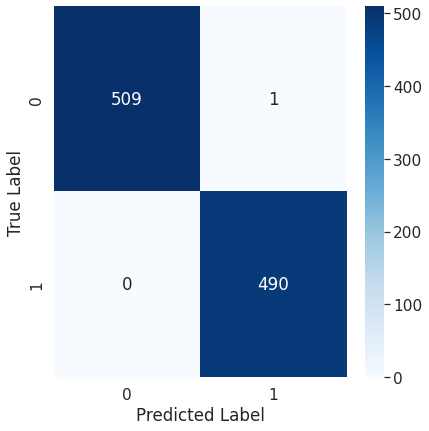

In [40]:
import seaborn as sns 
figure =plt.figure(figsize=(6,6))
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix,annot=True,cmap=plt.cm.Blues,fmt='g')
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [41]:
tn, fp, fn, tp =confusion_matrix.ravel()

In [42]:
#Calculating recall
recall=tp/(tp+fp)
print(f'recall: {recall}')
#Calculating precision
precision=tp/(tp+fn)
print(f'precision: {precision}')
#Calculating f1-score
f1_score=(precision*recall)/(precision+recall)
print(f'f1_score: {f1_score}')
#Calculating accuracy
accuracy=(tn+tp)/(tn+fp+fn+tp)
print(f'accuracy: {accuracy}')

recall: 0.9979633401221996
precision: 1.0
f1_score: 0.49949031600407745
accuracy: 0.999


In [44]:
#Saving the best model
model.save('/content/drive/MyDrive/best_model_x.h5')

In [46]:
!pip install CMake
!pip install dlib
!pip install face_recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100.1 MB 26 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=67aa810cf1c103d4e755722eb7ecc0dc1af47d2bbb08dd7a6cd89d6dc76f8265
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [47]:
import cv2 ## for the webcam and computer vision
import numpy as np 
from playsound import playsound ## alert sound
from PIL import Image, ImageDraw
import face_recognition ## face recognition
from tensorflow import keras ## for loading in the model

In [48]:
def eye_cropper(frame):

    # create a variable for the facial feature coordinates

    facial_features_list = face_recognition.face_landmarks(frame)


    # create a placeholder list for the eye coordinates
    # and append coordinates for eyes to list unless eyes
    # weren't found by facial recognition

    try:
        eye = facial_features_list[0]['left_eye']
    except:
        try:
            eye = facial_features_list[0]['right_eye']
        except:
            return


    # establish the max x and y coordinates of the eye

    x_max = max([coordinate[0] for coordinate in eye])
    x_min = min([coordinate[0] for coordinate in eye])
    y_max = max([coordinate[1] for coordinate in eye])
    y_min = min([coordinate[1] for coordinate in eye])


    # establish the range of x and y coordinates

    x_range = x_max - x_min
    y_range = y_max - y_min


      # in order to make sure the full eye is captured,
      # calculate the coordinates of a square that has a
      # 50% cushion added to the axis with a larger range and
      # then match the smaller range to the cushioned larger range

    if x_range > y_range:
        right = round(.5*x_range) + x_max
        left = x_min - round(.5*x_range)
        bottom = round((((right-left) - y_range))/2) + y_max
        top = y_min - round((((right-left) - y_range))/2)
    else:
        bottom = round(.5*y_range) + y_max
        top = y_min - round(.5*y_range)
        right = round((((bottom-top) - x_range))/2) + x_max
        left = x_min - round((((bottom-top) - x_range))/2)


    # crop the image according to the coordinates determined above

    cropped = frame[top:(bottom + 1), left:(right + 1)]

    # resize the image

    cropped = cv2.resize(cropped, (80,80))
    image_for_prediction = cropped.reshape(-1, 80, 80, 3)


    return image_for_prediction

In [49]:
eye_model = keras.models.load_model('/content/drive/MyDrive/best_model_x.h5')

In [56]:
# initiate webcam

cap = cv2.VideoCapture()
w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
print(cap.get(cv2.CAP_PROP_FPS))


if not cap.isOpened():
    raise IOError('Cannot open webcam')

# set a counter

counter = 0

# create a while loop that runs while webcam is in use

while True:

    # capture frames being outputted by webcam

    ret, frame = cap.read()

    # use only every other frame to manage speed and memory usage

    frame_count = 0
    if frame_count == 0:
        frame_count += 1
        pass
    else:
        count = 0
        continue

    # function called on the frame

    image_for_prediction = eye_cropper(frame)
    try:
        image_for_prediction = image_for_prediction/255.0
    except:
        continue

    # get prediction from model

    prediction = eye_model.predict(image_for_prediction)

    # Based on prediction, display either "Open Eyes" or "Closed Eyes"

    if prediction < 0.5:
        counter = 0
        status = 'Open'

        cv2.rectangle(frame, (round(w/2) - 110,20), (round(w/2) + 110, 80), (38,38,38), -1)

        cv2.putText(frame, status, (round(w/2)-80,70), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 2, cv2.LINE_4)
        x1, y1,w1,h1 = 0,0,175,75
        ## Draw black backgroun rectangle
        cv2.rectangle(frame, (x1,x1), (x1+w1-20, y1+h1-20), (0,0,0), -1)
        ## Add text
        cv2.putText(frame, 'Active', (x1 +int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255,0),2)
    else:
        counter = counter + 1
        status = 'Closed'

        cv2.rectangle(frame, (round(w/2) - 110,20), (round(w/2) + 110, 80), (38,38,38), -1)

        cv2.putText(frame, status, (round(w/2)-104,70), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2, cv2.LINE_4)
        x1, y1,w1,h1 = 0,0,175,75
        ## Draw black backgroun rectangle
        cv2.rectangle(frame, (x1,x1), (x1+w1-20, y1+h1-20), (0,0,0), -1)
        ## Add text
        cv2.putText(frame, 'Active', (x1 +int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255,0),2)


        # if the counter is greater than 3, play and show alert that user is asleep

        if counter > 2:

            x1, y1, w1, h1 = 400,400,400,100
            
            cv2.rectangle(frame, (round(w/2) - 160, round(h) - 200), (round(w/2) + 160, round(h) - 120), (0,0,255), -1)

            cv2.putText(frame, 'DRIVER SLEEPING', (round(w/2)-136,round(h) - 146), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_4)

            cv2.imshow('Drowsiness Detection', frame)
            k = cv2.waitKey(1)
            ## Sound
            playsound('rooster.mov')
            counter = 1
            continue
    cv2.imshow('Drowsiness Detection', frame)
    k = cv2.waitKey(1)
    if k == 27:
        break
cap.release()
cv2.destroyAllWindows()

0.0


OSError: ignored